In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import glob
import math


import seaborn as sns
from scipy import stats
from IPython.display import display, HTML


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [2]:
PATH = os.getcwd()
PATH = os.path.join(PATH, 'labelled(RL2)')
PATH

'D:\\LifeSpark Technology\\labelled(RL2)'

In [3]:
EXT = "*.csv"
files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob.glob(os.path.join(path, EXT))]
len(files)

18

In [5]:
sns.set()
time_period = 15       #half second intervals 
step = int((1 - 0.25) * time_period)  #25% overlap

In [14]:
def csab(dfr, time_steps, step):

    N_FEATURES = 6
    segments = []
    labels = []
    for i in range(0, len(dfr) - time_steps, step):
#         ax = dfr['ax'].values[i: i + time_steps]
#         ay = dfr['ay'].values[i: i + time_steps]
#         az = dfr['az'].values[i: i + time_steps]
#         gx = dfr['gx'].values[i: i + time_steps]
#         gy = dfr['gy'].values[i: i + time_steps]
#         gz = dfr['gz'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(dfr['freezing'][i: i + time_steps])[0][0]
        segments.append(dfr.iloc[i:i + time_steps, :-1])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32)#.reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [20]:
X = np.empty((0,15,6))
y = np.empty((0))
X_left = np.empty((0,15,6))
y_left = np.empty((0))
X_right = np.empty((0,15,6))
y_right = np.empty((0))
for file in files:
    df = pd.read_csv(file,index_col=[0])
    f= list(df['freezing'])
    for i in range(1, len(f)):
        if (f[i]!= f[i-1] and f[i]==1):
            j = i-1
            while (j>=0 and (i-j)<=10):    #classiying prefreezing as freezing (10 iterations before actual freezing ~ 0.33 sec)
                f[j] = 1
                j-=1
    df['freezing'] = f
    df = df.drop(['turning'],axis=1)
    temp_x, temp_y = csab(df, time_period, step)
    X = np.append(X , temp_x, axis = 0)
    y = np.append(y, temp_y, axis = 0)
    if os.path.basename(file)[0] =='l':
        X_left = np.append(X_left, temp_x, axis = 0)
        y_left = np.append(y_left, temp_y, axis = 0)
    else:
        X_right = np.append(X_right, temp_x, axis = 0)
        y_right = np.append(y_right, temp_y, axis = 0)

In [21]:
X.shape

(22146, 15, 6)

In [22]:
y.shape

(22146,)

In [23]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.6)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [24]:
num_time_periods, num_sensors = 15, 6
num_classes = 1 #freezing

In [25]:
input_shape = (num_time_periods*num_sensors) #90
X_train = X_train.reshape(X_train.shape[0], input_shape)
X_valid = X_valid.reshape(X_valid.shape[0],input_shape)
print('x_train shape:', X_train.shape)
print('input_shape:', input_shape)

x_train shape: (13287, 90)
input_shape: 90


In [26]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [28]:
model_m = Sequential()
model_m.add(Reshape((time_period, num_sensors), input_shape=(input_shape,)))
model_m.add(Dense(200, activation='relu'))
model_m.add(Dense(200, activation='relu'))
model_m.add(Dense(200, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(1, activation='sigmoid'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 15, 6)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 15, 200)           1400      
_________________________________________________________________
dense_5 (Dense)              (None, 15, 200)           40200     
_________________________________________________________________
dense_6 (Dense)              (None, 15, 200)           40200     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 3001      
Total params: 84,801
Trainable params: 84,801
Non-trainable params: 0
__________________________________________________

In [29]:
model_m.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(X_valid, y_valid),
                      verbose=1)

Epoch 1/25
34/34 [==============================] - 125s 54ms/step - loss: 0.5964 - accuracy: 0.6845 - val_loss: 0.5211 - val_accuracy: 0.7575
Epoch 2/25
34/34 [==============================] - 1s 20ms/step - loss: 0.5132 - accuracy: 0.7585 - val_loss: 0.4961 - val_accuracy: 0.7652
Epoch 3/25
34/34 [==============================] - 0s 14ms/step - loss: 0.4893 - accuracy: 0.7710 - val_loss: 0.4669 - val_accuracy: 0.7760
Epoch 4/25
34/34 [==============================] - 0s 14ms/step - loss: 0.4710 - accuracy: 0.7771 - val_loss: 0.4634 - val_accuracy: 0.7733
Epoch 5/25
34/34 [==============================] - 0s 14ms/step - loss: 0.4519 - accuracy: 0.7811 - val_loss: 0.4427 - val_accuracy: 0.7916
Epoch 6/25
34/34 [==============================] - 1s 15ms/step - loss: 0.4385 - accuracy: 0.7902 - val_loss: 0.4422 - val_accuracy: 0.7916
Epoch 7/25
34/34 [==============================] - 0s 15ms/step - loss: 0.4417 - accuracy: 0.7852 - val_loss: 0.4326 - val_accuracy: 0.7966
Epoch 8/25


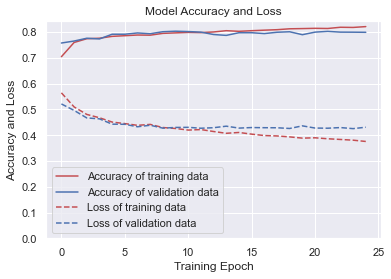

In [30]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

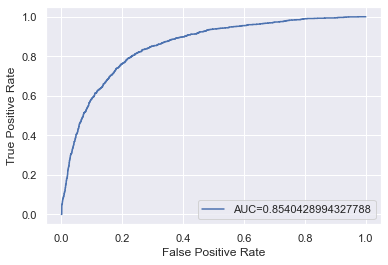

In [31]:
X_test = X_test.reshape(X_test.shape[0], input_shape)
y_pred_prob = model_m.predict(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [32]:
y_pred_test = np.where(y_pred_prob > 0.5, 1, 0)
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
accuracy_score(y_test, y_pred_test)

[[2598  364]
 [ 542  926]]


0.7954853273137698

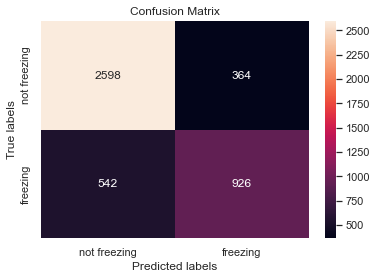

In [33]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not freezing', 'freezing']); ax.yaxis.set_ticklabels(['not freezing', 'freezing']);

In [34]:
y_test

array([0., 0., 0., ..., 1., 0., 1.])

In [35]:
y_pred_test

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [36]:
#for left
X_train_left, X_rem_left, y_train_left, y_rem_left = train_test_split(X_left,y_left, train_size=0.6, random_state = 42)
X_valid_left, X_test_left, y_valid_left, y_test_left = train_test_split(X_rem_left,y_rem_left, test_size=0.5, random_state = 42)

In [37]:
X_train_left = X_train_left.reshape(X_train_left.shape[0], input_shape)
X_valid_left = X_valid_left.reshape(X_valid_left.shape[0], input_shape)
X_test_left = X_test_left.reshape(X_test_left.shape[0], input_shape)

In [38]:
model_l = Sequential()
model_l.add(Reshape((time_period, 6), input_shape=(input_shape,)))
model_l.add(Dense(200, activation='relu'))
model_l.add(Dense(200, activation='relu'))
model_l.add(Dense(200, activation='relu'))
model_l.add(Flatten())
model_l.add(Dense(1, activation='sigmoid'))
print(model_l.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 15, 6)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 15, 200)           1400      
_________________________________________________________________
dense_9 (Dense)              (None, 15, 200)           40200     
_________________________________________________________________
dense_10 (Dense)             (None, 15, 200)           40200     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 3001      
Total params: 84,801
Trainable params: 84,801
Non-trainable params: 0
__________________________________________________

In [39]:
model_l.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history_l = model_l.fit(X_train_left,
                      y_train_left,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(X_valid_left, y_valid_left),
                      verbose=1)

Epoch 1/25
17/17 [==============================] - 2s 63ms/step - loss: 0.6147 - accuracy: 0.6431 - val_loss: 0.5159 - val_accuracy: 0.7589
Epoch 2/25
17/17 [==============================] - 0s 21ms/step - loss: 0.4982 - accuracy: 0.7698 - val_loss: 0.4913 - val_accuracy: 0.7761
Epoch 3/25
17/17 [==============================] - 0s 20ms/step - loss: 0.4814 - accuracy: 0.7808 - val_loss: 0.4732 - val_accuracy: 0.7815
Epoch 4/25
17/17 [==============================] - 0s 20ms/step - loss: 0.4625 - accuracy: 0.7828 - val_loss: 0.4608 - val_accuracy: 0.7901
Epoch 5/25
17/17 [==============================] - 0s 20ms/step - loss: 0.4394 - accuracy: 0.8046 - val_loss: 0.4576 - val_accuracy: 0.7955
Epoch 6/25
17/17 [==============================] - 0s 22ms/step - loss: 0.4352 - accuracy: 0.8017 - val_loss: 0.4781 - val_accuracy: 0.7765
Epoch 7/25
17/17 [==============================] - 0s 20ms/step - loss: 0.4412 - accuracy: 0.7919 - val_loss: 0.4383 - val_accuracy: 0.7950
Epoch 8/25
17

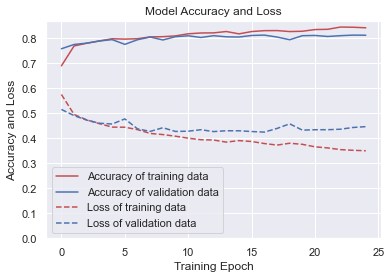

In [40]:
plt.figure(figsize=(6, 4))
plt.plot(history_l.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history_l.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history_l.history['loss'], 'r--', label='Loss of training data')
plt.plot(history_l.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

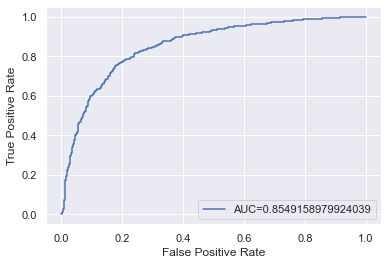

In [41]:
y_pred_prob_left = model_l.predict(X_test_left)

fpr, tpr, _ = metrics.roc_curve(y_test_left,  y_pred_prob_left)
auc = metrics.roc_auc_score(y_test_left, y_pred_prob_left)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [42]:
y_pred_test_left = np.where(y_pred_prob_left > 0.5, 1, 0)
cm_l = confusion_matrix(y_test_left, y_pred_test_left)
print(cm_l)
accuracy_score(y_test_left, y_pred_test_left)

[[1268  187]
 [ 272  488]]


0.7927765237020316

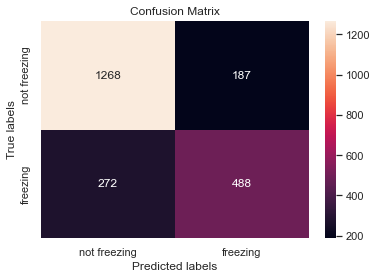

In [43]:
ax= plt.subplot()
sns.heatmap(cm_l, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['not freezing', 'freezing']); ax.yaxis.set_ticklabels(['not freezing', 'freezing']);

In [44]:
#right
X_train_right, X_rem_right, y_train_right, y_rem_right = train_test_split(X_right,y_right, train_size=0.6, random_state = 42)
X_valid_right, X_test_right, y_valid_right, y_test_right = train_test_split(X_rem_right,y_rem_right, test_size=0.5, random_state = 42)
X_train_right = X_train_right.reshape(X_train_right.shape[0], input_shape)
X_valid_right = X_valid_right.reshape(X_valid_right.shape[0], input_shape)
X_test_right = X_test_right.reshape(X_test_right.shape[0], input_shape)

In [45]:
model_r = Sequential()
model_r.add(Reshape((time_period, 6), input_shape=(input_shape,)))
model_r.add(Dense(200, activation='relu'))
model_r.add(Dense(200, activation='relu'))
model_r.add(Dense(200, activation='relu'))
model_r.add(Flatten())
model_r.add(Dense(1, activation='sigmoid'))
print(model_r.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 15, 6)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 15, 200)           1400      
_________________________________________________________________
dense_13 (Dense)             (None, 15, 200)           40200     
_________________________________________________________________
dense_14 (Dense)             (None, 15, 200)           40200     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3000)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3001      
Total params: 84,801
Trainable params: 84,801
Non-trainable params: 0
__________________________________________________

In [46]:
model_r.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history_r = model_r.fit(X_train_right,
                      y_train_right,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(X_valid_right, y_valid_right),
                      verbose=1)

Epoch 1/25
17/17 [==============================] - 2s 47ms/step - loss: 0.6735 - accuracy: 0.6046 - val_loss: 0.5386 - val_accuracy: 0.7372
Epoch 2/25
17/17 [==============================] - 0s 20ms/step - loss: 0.5427 - accuracy: 0.7454 - val_loss: 0.5194 - val_accuracy: 0.7679
Epoch 3/25
17/17 [==============================] - 0s 21ms/step - loss: 0.5139 - accuracy: 0.7596 - val_loss: 0.4931 - val_accuracy: 0.7684
Epoch 4/25
17/17 [==============================] - 0s 21ms/step - loss: 0.4913 - accuracy: 0.7645 - val_loss: 0.4766 - val_accuracy: 0.7770
Epoch 5/25
17/17 [==============================] - 0s 19ms/step - loss: 0.4662 - accuracy: 0.7758 - val_loss: 0.4619 - val_accuracy: 0.7801
Epoch 6/25
17/17 [==============================] - 0s 21ms/step - loss: 0.4524 - accuracy: 0.7881 - val_loss: 0.4491 - val_accuracy: 0.7797
Epoch 7/25
17/17 [==============================] - 0s 21ms/step - loss: 0.4477 - accuracy: 0.7834 - val_loss: 0.4445 - val_accuracy: 0.7896
Epoch 8/25
17

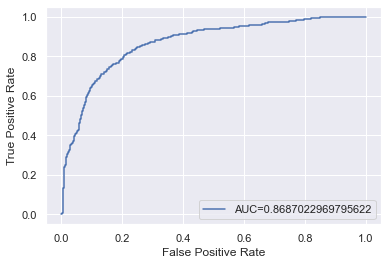

In [47]:
y_pred_prob_right = model_r.predict(X_test_right)

fpr, tpr, _ = metrics.roc_curve(y_test_right,  y_pred_prob_right)
auc = metrics.roc_auc_score(y_test_right, y_pred_prob_right)
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

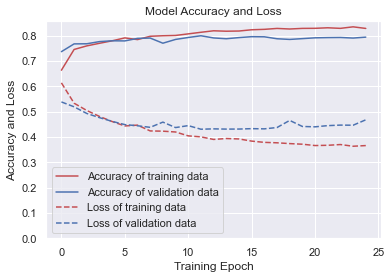

              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80      4438
         1.0       0.00      0.00      0.00      2205

    accuracy                           0.67      6643
   macro avg       0.33      0.50      0.40      6643
weighted avg       0.45      0.67      0.54      6643



In [48]:
plt.figure(figsize=(6, 4))
plt.plot(history_r.history['accuracy'], 'r', label='Accuracy of training data')
plt.plot(history_r.history['val_accuracy'], 'b', label='Accuracy of validation data')
plt.plot(history_r.history['loss'], 'r--', label='Loss of training data')
plt.plot(history_r.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train_right = model_r.predict(X_train_right)
# Take the class with the highest probability from the train predictions
max_y_pred_train_right = np.argmax(y_pred_train_right, axis=1)
print(classification_report(y_train_right, max_y_pred_train_right))

In [49]:
y_pred_test_right = np.where(y_pred_prob_right > 0.5, 1, 0)
cm_r = confusion_matrix(y_test_right, y_pred_test_right)
print(cm_r)
accuracy_score(y_test_right, y_pred_test_right)

[[1164  291]
 [ 164  596]]


0.7945823927765236